In [1]:
library(dplyr)
library(broom)
library(MASS)
library(ggplot2)
library(purrr)
library(tidyr)
library(knitr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Hmisc’:

    combine, src, summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [4]:
# horizon
n <- 10000

# reproducibility
set.seed(2)

# data simulation
data <- data_frame(
  feature_1 = sample(c(0,1), n, prob=c(0.6, 0.4), replace=T),
  feature_2 = sample(c(0,1), n, prob=c(0.7, 0.3), replace=T),
  arm = sample(c(1:3), n, replace=T),
  f1_coeff = case_when(arm == 1 ~ .5, arm == 2 ~ .1, arm == 3 ~ .1),
  f2_coeff = case_when(arm == 1 ~ .1, arm == 2 ~ .1, arm == 3 ~ .4),
  baseline = case_when(arm == 1 ~ .1, arm == 2 ~ .2, arm == 3 ~ .1),
  rand_draw = runif(n) # uniformly pick n numbers 
) %>%
  mutate(factor = baseline + f1_coeff * feature_1 + f2_coeff * feature_2) %>%
  mutate(click = ifelse(factor >= rand_draw, 1, 0))

In [5]:
data %>%
  group_by(arm, feature_1, feature_2) %>%
  summarise(ct = n(), reward = sum(click), mean_clk_rt = mean(click)) %>%
  group_by(feature_1, feature_2) %>%
  filter(mean_clk_rt == max(mean_clk_rt)) %>%
  kable()



| arm| feature_1| feature_2|   ct| reward| mean_clk_rt|
|---:|---------:|---------:|----:|------:|-----------:|
|   1|         1|         0|  930|    556|   0.5978495|
|   1|         1|         1|  420|    291|   0.6928571|
|   2|         0|         0| 1345|    257|   0.1910781|
|   3|         0|         1|  601|    299|   0.4975042|

In [7]:
alpha = 3 # alpha set manually here

# ucb estimates
ucb <- function(inverse_cov_matrix, reward_vector_times_design_matrix, context_vector, alpha){
  theta_hat <- inverse_cov_matrix %*% reward_vector_times_design_matrix
  ucb_estimate <- t(theta_hat) %*% context_vector + 
    alpha * sqrt(t(context_vector) %*% inverse_cov_matrix %*% context_vector)
  return(ucb_estimate)
}

# updates the covariate matrix
update_cov_matrix <- function(cov_matrix, context_vector){
  return(cov_matrix + context_vector %*% t(context_vector))
}

# updates b_a from above
update_reward_vector_times_design_matrix <- function(reward_vector_times_design_matrix, reward, context_vector){
  return(reward_vector_times_design_matrix + reward * context_vector)
}

In [8]:
arms <- c(1:3) # 3 arms
d <- 2 # 2 features

# initialization
arm_choice <- c()
cov_matrix <- list()
reward_vector_times_design_matrix <- list() # this corresponds to b_a above
ucb_estimate <- matrix(0, n, length(arms))

In [13]:
# disjoint model
for (t in 1:n){
  context <- data[t,]
  for (a in arms){
    if(t == 1){
      cov_matrix[[a]] <- diag(d)
      reward_vector_times_design_matrix[[a]] <- rep(0, d)
    }
    inverse_cov_matrix <- ginv(cov_matrix[[a]])
    ucb_estimate[t, a] <- ucb(inverse_cov_matrix, 
                    as.matrix(reward_vector_times_design_matrix[[a]]), 
                    as.matrix(c(context$feature_1, context$feature_2)), 
                    alpha)
  }
  trial_arm <- which(ucb_estimate[t,] == max(ucb_estimate[t,]))
  if(length(trial_arm) > 1){
    trial_arm <- sample(trial_arm, 1)
  }
  if(trial_arm == context$arm){
    arm_choice[t] <- trial_arm
  }else{
    arm_choice[t] <- t*10 # need to do this so I can filter out unused observations from bandit dataset
    next
  }
  cov_matrix[[arm_choice[t]]] <- update_cov_matrix(cov_matrix[[arm_choice[t]]], 
                                                as.matrix(c(context$feature_1, context$feature_2)))
  reward_vector_times_design_matrix[[arm_choice[t]]] <- update_reward_vector_times_design_matrix(
    as.matrix(reward_vector_times_design_matrix[[arm_choice[t]]]),
    context$click,
    as.matrix(c(context$feature_1, context$feature_2))
  )
}

In [15]:
data$arm_choice <- arm_choice

# create a function to apply to the list columns of the bandit data
lm_fun <- function(dat){
  return(tidy(summary(lm(click ~ 0 + feature_1 + feature_2, dat))))
}

# apply the lm function to each arm's data from the original dataset
data %>%
  nest(-arm) %>%
  mutate(model = map(data, lm_fun)) %>%
  unnest(model) %>%
  dplyr::select(arm, term, data_estimate = estimate) %>%
  arrange(arm) -> coefficients_from_data

# calculate the coefficients for each of the arms using the bandit data
map_df(arms, function(i) data_frame(arm = i, term = c("feature_1", "feature_2"), bandit_estimate = as.vector(ginv(cov_matrix[[i]]) %*% reward_vector_times_design_matrix[[i]]))) -> coefficients_from_bandit

# join them together and see how different they are
coefficients_from_data %>%
  inner_join(coefficients_from_bandit, by = c("arm", "term")) %>%
  mutate(percent_difference = 100*((bandit_estimate - data_estimate)/data_estimate)) -> estimate_data

In [16]:
kable(estimate_data)



| arm|term      | data_estimate| bandit_estimate| percent_difference|
|---:|:---------|-------------:|---------------:|------------------:|
|   1|feature_1 |     0.5746100|       0.6001210|           4.439695|
|   1|feature_2 |     0.1697058|       0.1011976|         -40.368813|
|   2|feature_1 |     0.2663637|       0.2396774|         -10.018762|
|   2|feature_2 |     0.2367721|       0.2498560|           5.525945|
|   3|feature_1 |     0.1792482|       0.0321503|         -82.063809|
|   3|feature_2 |     0.4627396|       0.4933666|           6.618618|

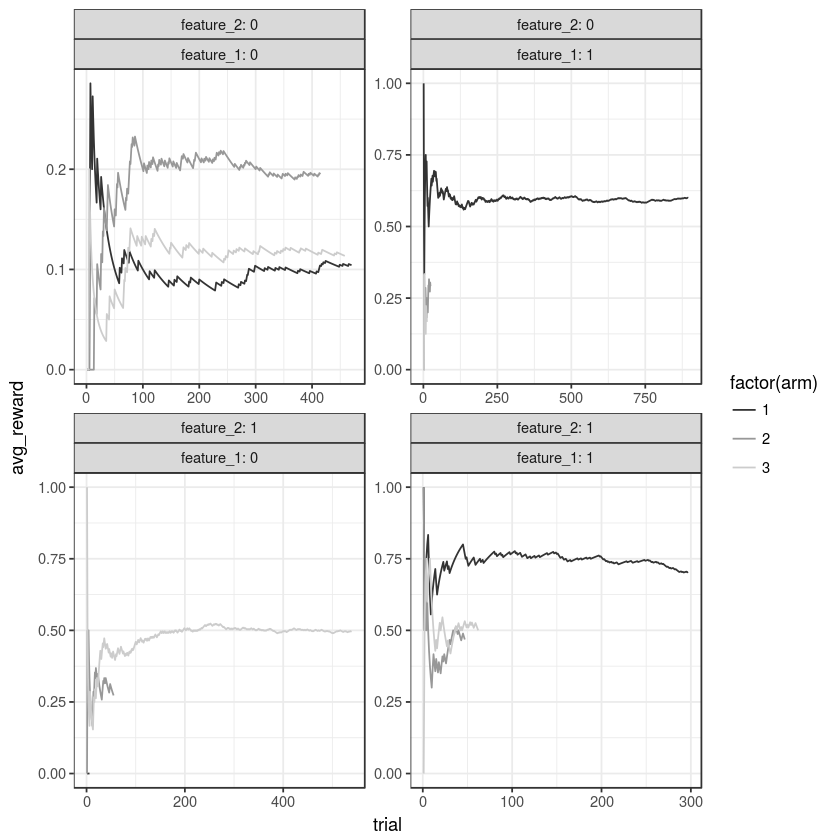

In [18]:
data %>%
  filter(arm_choice < 10) %>%
  group_by(feature_1, feature_2, arm_choice) %>%
  mutate(total_reward = cumsum(click), trial = c(1:n())) %>%
  mutate(avg_reward = total_reward/trial) %>%
  ggplot(aes(x = trial, y = avg_reward, color = factor(arm), group = factor(arm))) +
  geom_path() +
  facet_wrap(~feature_2 + feature_1, scales = "free", labeller = "label_both") +
  theme_bw() +
  scale_colour_grey()